# Installing the required dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

Added six different libraries
- Tensorflow
- Tensoflow-gpu
- openCV (Computer Vision library)
- mediapipe (allows to get keypoints from your face and head)
- sklearn
- matplotlib

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Implement the keypoints and mediapipe holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing the utilities

In [8]:
# Defining the function to detect our image based on the model
def mediapipe_detection(image, model):
    # This line helps in the color conversion from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # This makes the image no longer writable.
    image.flags.writeable = False
    
    # helps make the prediction
    results = model.process(image)
    
    # Makes the image writable.
    image.flags.writeable = True
    
    # This converts the color again from RGB to BGR.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Returns our image and results back to our loop.
    return image, results

In [9]:
# this function grabs the results and maps landmarks to the image.
def draw_landmarks(image,results):
    # Draws the points on the face
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    # Draws the points on the pose
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    # Draws the points on the Right Hand
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    # Draws the points on the left Hand
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [10]:
# Run this new function for improved data points on the live stream

def draw_styled_landmarks(image,results):
    # Draws the points on the face
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))
    # Draws the points on the pose
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))
    # Draws the points on the Right Hand
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))
    # Draws the points on the left Hand
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=1))

In [21]:
# writing a loop to do a video capture

cap = cv2.VideoCapture(0)

# Setting the mediapipe model while capturing image.
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened(): #opens the webcam

        #Reads the feed from the webcam
        ret, frame = cap.read()

        # Inserting the detection code below.
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        # Draw the landmarks to our live feed
        #draw_landmarks(image, results)
        draw_styled_landmarks(image, results)
        
        #shows the feed to the screen, pass the frame or image from webcam.
        cv2.imshow('OpenCV Feed', image)

        # Stops the video once we escape from the loop
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    # After the break it will let go of our webcam.
    cap.release()
    # Deletes or closes the window.
    cv2.destroyAllWindows()

In [12]:
len(results.pose_world_landmarks.landmark)

33

In [13]:
draw_styled_landmarks(frame, results)

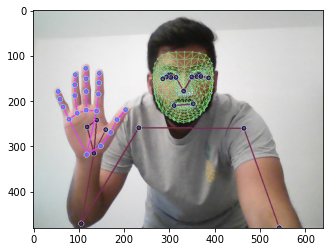

In [14]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract the keypoint values from the output

In [15]:
# Concatenate results values into a numpy array
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()if results.right_hand_landmarks else np.zeros(21*3)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()if results.right_hand_landmarks else np.zeros(1404)
    return np.concatenate([pose,face,lh,rh])

In [16]:
extract_keypoints(results).shape

(1662,)

In [17]:
result_test = extract_keypoints(results)

In [18]:
result_test

array([ 0.51996136,  0.37213582, -1.41439593, ...,  0.08610477,
        0.37423933, -0.07209396])

In [ ]:
np.save('0', result_test)

In [ ]:
np.load('0.npy')

# Setting up the folder for creating the collection

In [19]:
# Creating the path to export the data of numpy array
DATA_PATH = os.path.join('MP_data')

# Specify the actions that need to be detected.
actions = np.array(['hello', 'thanks','Iloveyou'])

# Specify the number of videos of data to select.
no_sequences = 30

# Video are be 30 frames in length
sequence_length = 30

In [20]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# Collecting keypoint values for training and testing our data.

In [22]:
# writing a loop to take a snapshot in each point of time.

cap = cv2.VideoCapture(0)

# Setting the mediapipe model while capturing image.
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through each action
    for action in actions:
        # Loops through the sequences in videos
        for sequence in range(no_sequences):
            #Loop through video length aka sequence length
            for frame_num in range(sequence_length):
        

                #Reads the feed from the webcam
                ret, frame = cap.read()

                # Inserting the detection code below.
                image, results = mediapipe_detection(frame, holistic)
                #print(results)


                # Draw the landmarks to our live feed
                #draw_landmarks(image, results)
                draw_styled_landmarks(image, results)

                # Apply the logic for collecting 

                # If frame is 0 then excute the following
                if frame_num == 0:

                    #The following code outputs text in our screen
                    cv2.putText(image, 'STARTING COLLECTION',(120,200),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)

                    cv2.putText(image, 'Collecting frame for {} Video Number {}'.format(action,sequence), (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, 'Collecting frame for {} Video Number {}'.format(action, sequence), (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)

                    # shows the feed to the screen, pass the frame or image from webcam.
                    cv2.imshow('OpenCV Feed', image)
                    
                # This code collects the keypoints and saves it in the root folder.
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)


                # Stops the video once we escape from the loop
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    # After the break it will let go of our webcam.
    cap.release()
    # Deletes or closes the window.
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

# Preprocess our data and create the labels and features from the recorded material

In [71]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [72]:
label_map = {label:num for num, label in enumerate(actions)}

In [73]:
label_map

{'hello': 0, 'thanks': 1, 'Iloveyou': 2}

In [74]:

# Creating two new blank array, sequences is representing our X data and labels will be the Y data.
sequences, labels = [], []

# Created a loop through each of our actions.
for action in actions:
    # Loop through each of the thirty videos
    for sequence in range(no_sequences):
        # For each loop we will create a blank window array, reps all the frames for a sequence
        window = []
        # Loop for each frame
        for frame_num in range(sequence_length):
            # Loads the file and the appends to the window.
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
            # Grabbing the video and appending to the window.
        sequences.append(window)
        labels.append(label_map[action])

In [75]:
X = np.array(sequences)

In [76]:
X.shape

(90, 30, 1662)

In [77]:
y = to_categorical(labels).astype(int)

In [78]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# Build and train our LSTM neural network!

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [81]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [82]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation = 'relu', input_shape = (30,1662)))
model.add(LSTM(128, return_sequences=True, activation = 'relu'))
model.add(LSTM(64, return_sequences=False, activation = 'relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [83]:
# Compile our model. Using the categorical crossentropy as we have a multi-class classificational model.
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [87]:
# Fitting our model.
model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback])

Epoch 1/500
3/3 [==============================] - 0s 93ms/step - loss: 0.8572 - categorical_accuracy: 0.6118
Epoch 2/500
3/3 [==============================] - 0s 39ms/step - loss: 0.9255 - categorical_accuracy: 0.6000
Epoch 3/500
3/3 [==============================] - 0s 37ms/step - loss: 0.8993 - categorical_accuracy: 0.5294
Epoch 4/500
3/3 [==============================] - 0s 37ms/step - loss: 0.8702 - categorical_accuracy: 0.6235
Epoch 5/500
3/3 [==============================] - 0s 37ms/step - loss: 0.8970 - categorical_accuracy: 0.4471
Epoch 6/500
3/3 [==============================] - 0s 39ms/step - loss: 0.8840 - categorical_accuracy: 0.5059
Epoch 7/500
3/3 [==============================] - 0s 41ms/step - loss: 0.9468 - categorical_accuracy: 0.6235
Epoch 8/500
3/3 [==============================] - 0s 36ms/step - loss: 0.8537 - categorical_accuracy: 0.6118
Epoch 9/500
3/3 [==============================] - 0s 37ms/step - loss: 0.8400 - categorical_accuracy: 0.5882
Epoch 10/5

3/3 [==============================] - 0s 40ms/step - loss: 0.7716 - categorical_accuracy: 0.6706
Epoch 75/500
3/3 [==============================] - 0s 37ms/step - loss: 0.7263 - categorical_accuracy: 0.7059
Epoch 76/500
3/3 [==============================] - 0s 37ms/step - loss: 0.7544 - categorical_accuracy: 0.6000
Epoch 77/500
3/3 [==============================] - 0s 37ms/step - loss: 0.7400 - categorical_accuracy: 0.5882
Epoch 78/500
3/3 [==============================] - 0s 37ms/step - loss: 0.6851 - categorical_accuracy: 0.7647
Epoch 79/500
3/3 [==============================] - 0s 39ms/step - loss: 0.7138 - categorical_accuracy: 0.6118
Epoch 80/500
3/3 [==============================] - 0s 37ms/step - loss: 0.6417 - categorical_accuracy: 0.7765
Epoch 81/500
3/3 [==============================] - 0s 41ms/step - loss: 0.6323 - categorical_accuracy: 0.7647
Epoch 82/500
3/3 [==============================] - 0s 39ms/step - loss: 0.6643 - categorical_accuracy: 0.6706
Epoch 83/500
3

3/3 [==============================] - 0s 37ms/step - loss: 0.4275 - categorical_accuracy: 0.8353
Epoch 148/500
3/3 [==============================] - 0s 37ms/step - loss: 0.3990 - categorical_accuracy: 0.8588
Epoch 149/500
3/3 [==============================] - 0s 38ms/step - loss: 0.3945 - categorical_accuracy: 0.8941
Epoch 150/500
3/3 [==============================] - 0s 37ms/step - loss: 0.4028 - categorical_accuracy: 0.8353
Epoch 151/500
3/3 [==============================] - 0s 37ms/step - loss: 0.4260 - categorical_accuracy: 0.7882
Epoch 152/500
3/3 [==============================] - 0s 38ms/step - loss: 0.4329 - categorical_accuracy: 0.8353
Epoch 153/500
3/3 [==============================] - 0s 37ms/step - loss: 0.3998 - categorical_accuracy: 0.8235
Epoch 154/500
3/3 [==============================] - 0s 37ms/step - loss: 0.4079 - categorical_accuracy: 0.8000
Epoch 155/500
3/3 [==============================] - 0s 37ms/step - loss: 0.4133 - categorical_accuracy: 0.8353
Epoch 

3/3 [==============================] - 0s 38ms/step - loss: 0.2818 - categorical_accuracy: 0.9176
Epoch 221/500
3/3 [==============================] - 0s 39ms/step - loss: 0.2926 - categorical_accuracy: 0.8471
Epoch 222/500
3/3 [==============================] - 0s 39ms/step - loss: 0.2827 - categorical_accuracy: 0.9059
Epoch 223/500
3/3 [==============================] - 0s 37ms/step - loss: 0.3137 - categorical_accuracy: 0.8941
Epoch 224/500
3/3 [==============================] - 0s 37ms/step - loss: 0.2924 - categorical_accuracy: 0.8824
Epoch 225/500
3/3 [==============================] - 0s 36ms/step - loss: 0.2836 - categorical_accuracy: 0.8471
Epoch 226/500
3/3 [==============================] - 0s 38ms/step - loss: 0.2967 - categorical_accuracy: 0.9059
Epoch 227/500
3/3 [==============================] - 0s 36ms/step - loss: 0.2672 - categorical_accuracy: 0.9294
Epoch 228/500
3/3 [==============================] - 0s 36ms/step - loss: 0.2790 - categorical_accuracy: 0.8471
Epoch 

3/3 [==============================] - 0s 39ms/step - loss: 0.2535 - categorical_accuracy: 0.8706
Epoch 294/500
3/3 [==============================] - 0s 39ms/step - loss: 0.2129 - categorical_accuracy: 0.9294
Epoch 295/500
3/3 [==============================] - 0s 37ms/step - loss: 0.2645 - categorical_accuracy: 0.9176
Epoch 296/500
3/3 [==============================] - 0s 39ms/step - loss: 0.1970 - categorical_accuracy: 0.9529
Epoch 297/500
3/3 [==============================] - 0s 40ms/step - loss: 0.2522 - categorical_accuracy: 0.9059
Epoch 298/500
3/3 [==============================] - 0s 39ms/step - loss: 0.2266 - categorical_accuracy: 0.9176
Epoch 299/500
3/3 [==============================] - 0s 39ms/step - loss: 0.2141 - categorical_accuracy: 0.9176
Epoch 300/500
3/3 [==============================] - 0s 39ms/step - loss: 0.2345 - categorical_accuracy: 0.9294
Epoch 301/500
3/3 [==============================] - 0s 39ms/step - loss: 0.2098 - categorical_accuracy: 0.9294
Epoch 

3/3 [==============================] - 0s 41ms/step - loss: 0.2150 - categorical_accuracy: 0.9176
Epoch 367/500
3/3 [==============================] - 0s 38ms/step - loss: 0.1826 - categorical_accuracy: 0.9294
Epoch 368/500
3/3 [==============================] - 0s 39ms/step - loss: 0.2093 - categorical_accuracy: 0.9294
Epoch 369/500
3/3 [==============================] - 0s 49ms/step - loss: 0.1889 - categorical_accuracy: 0.9294
Epoch 370/500
3/3 [==============================] - 0s 41ms/step - loss: 0.1953 - categorical_accuracy: 0.9412
Epoch 371/500
3/3 [==============================] - 0s 40ms/step - loss: 0.2431 - categorical_accuracy: 0.9294
Epoch 372/500
3/3 [==============================] - 0s 40ms/step - loss: 0.2098 - categorical_accuracy: 0.9294
Epoch 373/500
3/3 [==============================] - 0s 40ms/step - loss: 0.2043 - categorical_accuracy: 0.9176
Epoch 374/500
3/3 [==============================] - 0s 43ms/step - loss: 0.1861 - categorical_accuracy: 0.9529
Epoch 

3/3 [==============================] - 0s 39ms/step - loss: 0.1591 - categorical_accuracy: 0.9412
Epoch 440/500
3/3 [==============================] - 0s 38ms/step - loss: 0.1527 - categorical_accuracy: 0.9412
Epoch 441/500
3/3 [==============================] - 0s 39ms/step - loss: 0.2279 - categorical_accuracy: 0.8941
Epoch 442/500
3/3 [==============================] - 0s 38ms/step - loss: 0.2233 - categorical_accuracy: 0.9176
Epoch 443/500
3/3 [==============================] - 0s 38ms/step - loss: 0.1484 - categorical_accuracy: 0.9529
Epoch 444/500
3/3 [==============================] - 0s 38ms/step - loss: 0.1617 - categorical_accuracy: 0.9412
Epoch 445/500
3/3 [==============================] - 0s 38ms/step - loss: 0.1726 - categorical_accuracy: 0.9412
Epoch 446/500
3/3 [==============================] - 0s 39ms/step - loss: 0.2225 - categorical_accuracy: 0.9294
Epoch 447/500
3/3 [==============================] - 0s 39ms/step - loss: 0.1602 - categorical_accuracy: 0.9529
Epoch 

In [88]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 30, 64)            442112    
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
________________________________________________

# Make the prediction

In [89]:
res = model.predict(X_test)

In [90]:
actions[np.argmax(res[1])]

'hello'

# Save the weights

In [91]:
model.save('action.h5')

In [92]:
model.load_weights('action.h5')

In [49]:
del model

NameError: name 'model' is not defined

# Evaluate our model using a confusion matrix and accuracy

In [93]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [94]:
yhat = model.predict(X_test)

In [95]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [96]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[1, 1],
        [0, 3]],

       [[3, 0],
        [1, 1]]], dtype=int64)

In [97]:
accuracy_score(ytrue, yhat) 

0.8

# Test our model in real time

In [ ]:

# 1) Create our new detection variables

sequence = []
sentence = []
threshold = 0.4

cap = cv2.VideoCapture(0)

# Setting the mediapipe model while capturing image.
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened(): #opens the webcam

        #Reads the feed from the webcam
        ret, frame = cap.read()

        # Inserting the detection code below.
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        # Draw the landmarks to our live feed
        #draw_landmarks(image, results)
        draw_styled_landmarks(image, results)
        
        
        # 2) Develop the prediction logic on the live feed.
        
        # Defining the variable keypoints which is the extract of the results.
        keypoints = extract_keypoints(results)
        sequence.insert(0,keypoints)
        
        # Grabbing our last 30 frames 
        sequence = sequence[:30]
        
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
        
        #shows the feed to the screen, pass the frame or image from webcam.
        cv2.imshow('OpenCV Feed', image)

        # Stops the video once we escape from the loop
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    # After the break it will let go of our webcam.
    cap.release()
    # Deletes or closes the window.
    cv2.destroyAllWindows()

In [99]:
# Predict a model
model.predict(np.expand_dims(X_test[0], axis=[0]))

array([[9.8041362e-01, 9.9597664e-06, 1.9576417e-02]], dtype=float32)